In [37]:
# SRC: https://realpython.com/numpy-array-programming/#what-is-vectorization
from timeit import timeit

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy_financial as npf

from skimage import io
from numpy.lib import stride_tricks


# Counting: Easy as 1, 2, 3…

In [2]:
def count_transitions_1(x):
    count = 0
    for i, j in zip(x[:-1], x[1:]):
        if j and not i:
            count += 1

    return count


def count_transitions_2(x):
    return sum(i < j for i, j in zip(x[:-1], x[1:]))


def count_transitions_3(x):
    return sum(1 for i, j in zip(x[:-1], x[1:]) if i < j)


def count_transitions_4(x):
    return np.count_nonzero(x[:-1] < x[1:])


np.random.seed(444)
x = np.random.choice([False, True], size=100000)
print(count_transitions_1(x))
print(count_transitions_2(x))
print(count_transitions_3(x))
print(count_transitions_4(x))

24984
24984
24984
24984


In [3]:
setup = 'from __main__ import count_transitions_1, count_transitions_2, count_transitions_3, count_transitions_4, x; import numpy as np'
num = 3
t1 = t2 = t3 = t4 = 0
for i in range(10):
	t1 += timeit('count_transitions_1(x)', setup=setup, number=num)
	t2 += timeit('count_transitions_2(x)', setup=setup, number=num)
	t3 += timeit('count_transitions_3(x)', setup=setup, number=num)
	t4 += timeit('count_transitions_4(x)', setup=setup, number=num)

print(t1)
print(t2)
print(t3)
print(t4)

print(f'Speed difference: {t1 / t4:0.1f}x')
print(f'Speed difference: {t2 / t4:0.1f}x')
print(f'Speed difference: {t3 / t4:0.1f}x')

0.9787318600006074
12.14057088799882
10.25361113999952
0.013466417000927322
Speed difference: 72.7x
Speed difference: 901.5x
Speed difference: 761.4x


# Buy Low, Sell High


In [4]:
def profit(prices):
    max_px = 0
    min_px = prices[0]
    for px in prices[1:]:
        min_px = min(min_px, px)
        max_px = max(px - min_px, max_px)
    return max_px

prices = (20, 18, 14, 17, 20, 21, 15)
profit(prices)

7

In [5]:
prices = np.full(100, fill_value=np.nan)
prices[[0, 25, 60, -1]] = [80., 30., 75., 50.]

x = np.arange(len(prices))
is_valid = ~np.isnan(prices)
prices = np.interp(x=x, xp=x[is_valid], fp=prices[is_valid])
prices += np.random.randn(len(prices)) * 2

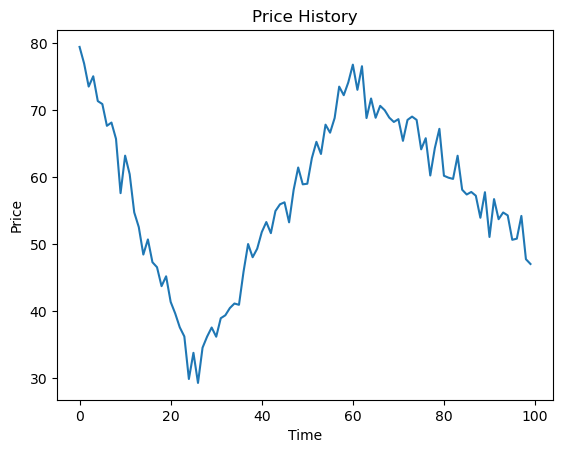

In [6]:
mn = np.argmin(prices)
mx = mn + np.argmax(prices[mn:])
kwargs = {'markersize': 12, 'linestyle': ''}

fig, ax = plt.subplots()
ax.plot(prices)
ax.set_title('Price History')
ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.plot(mn, prices[mn], color='green', **kwargs)
ax.plot(mx, prices[mx], color='red', **kwargs)

In [7]:
def profit_with_numpy(prices):
    """Price minus cumulative minimum price, element-wise."""
    prices = np.asarray(prices)
    return np.max(prices - np.minimum.accumulate(prices))

print(profit_with_numpy(prices))
print(np.allclose(profit_with_numpy(prices), profit(prices)))

47.51581018762879
True


In [8]:
seq = np.random.randint(0, 100, size=100000)

setup = ('from __main__ import profit_with_numpy, profit, seq; import numpy as np')
num = 200
pytime = timeit('profit(seq)', setup=setup, number=num)
nptime = timeit('profit_with_numpy(seq)', setup=setup, number=num)
print(f'Speed difference: {pytime / nptime:0.1f}x')

Speed difference: 111.0x


# Broadcasting

In [9]:
sample = np.random.normal(loc=[2., 20.], scale=[1., 3.5], size=(5, 2))
sample

array([[ 2.2261252 , 17.68916753],
       [ 1.91752374, 18.55904714],
       [ 2.88271815, 22.2076747 ],
       [ 1.09798757, 17.9694831 ],
       [ 0.77236779, 22.83452165]])

In [10]:
mu = sample.mean(axis=0)
mu

array([ 1.77934449, 19.85197883])

In [11]:
print('sample:', sample.shape, '| means:', mu.shape)
sample - mu

sample: (5, 2) | means: (2,)


array([[ 0.44678071, -2.16281129],
       [ 0.13817925, -1.29293169],
       [ 1.10337366,  2.35569588],
       [-0.68135692, -1.88249572],
       [-1.0069767 ,  2.98254283]])

In [12]:
(sample - sample.mean(axis=0)) / sample.std(axis=0)

array([[ 0.58520178, -0.98030332],
       [ 0.18098978, -0.58602673],
       [ 1.44521957,  1.06772907],
       [-0.89245412, -0.85324911],
       [-1.31895702,  1.35185009]])

In [13]:
sample - sample.min(axis=1)

ValueError: operands could not be broadcast together with shapes (5,2) (5,) 

In [ ]:
sample - sample.min(axis=1)[:, None]

In [ ]:
a = np.sin(np.arange(10)[:, None])
b = np.random.randn(1, 10)
c = np.full_like(a, 10)
d = 8

arrays = [np.atleast_1d(arr) for arr in (a, b, c, d)]
for arr in arrays:
    print(arr.shape)

In [ ]:
def can_broadcast(*arrays):
    arrays = [np.atleast_1d(arr) for arr in arrays]

    # rule 1: The arrays all have exactly the same shape.
    if len(set(arr.shape for arr in arrays)) == 1:
        return True

    # rule 2: The arrays all have the same number of dimensions, and the length of each dimension is either a common length or 1.
    if len(set(arr.ndim for arr in arrays)) == 1:
        return True

    # rule 3: The arrays that have too few dimensions can have their shapes prepended with a dimension of length 1 to satisfy rule #2.
    maxdim = max(arr.ndim for arr in arrays)
    shapes = np.array([(1,) * (maxdim - arr.ndim) + arr.shape for arr in arrays])
    masked = np.ma.masked_where(shapes == 1, shapes)
    return np.all(masked.ptp(axis=0) == 0)


def can_broadcast_2(*arrays):
    try:
        np.broadcast(*arrays)
        return True
    except ValueError:
        return False

print(can_broadcast(a, b, c, d))
print(can_broadcast_2(a, b, c, d))

# Clustering Algorithms

In [ ]:
tri = np.array([[1, 1],
                [3, 1],
                [2, 3]])

centroid = tri.mean(axis=0)
centroid

In [ ]:
trishape = plt.Polygon(tri, edgecolor='r', alpha=0.2, lw=5)
_, ax = plt.subplots(figsize=(4, 4))
ax.add_patch(trishape)
ax.set_ylim([.5, 3.5])
ax.set_xlim([.5, 3.5])
ax.scatter(*centroid, color='g', marker='D', s=70)
ax.scatter(*tri.T, color='b',  s=70)

In [ ]:
print(np.sum(tri**2, axis=1) ** 0.5)  # Or: np.sqrt(np.sum(np.square(tri), 1))
print(np.linalg.norm(tri, axis=1))  # Euclidean norms
print(np.linalg.norm(tri - centroid, axis=1))  # the norm of each point relative to the triangle’s centroid

In [ ]:
X = np.repeat([[5, 5], [10, 10]], [5, 5], axis=0)
X = X + np.random.randn(*X.shape)  # 2 distinct "blobs"
centroids = np.array([[5, 5], [10, 10]])
X

In [ ]:
def get_labels(X, centroids):
	# we need to extend centroids to make it broadcastable with X
	centroids = centroids[:, None]
	return np.argmin(np.linalg.norm(X - centroids, axis=2), axis=0)

labels = get_labels(X, centroids)
labels

In [ ]:
c1, c2 = ['#bc13fe', '#be0119']  # https://xkcd.com/color/rgb/
llim, ulim  = np.trunc([X.min() * 0.9, X.max() * 1.1])

_, ax = plt.subplots(figsize=(5, 5))
ax.scatter(*X.T, c=np.where(labels, c2, c1), alpha=0.4, s=80)
ax.scatter(*centroids.T, c=[c1, c2], marker='s', s=95,
           edgecolor='yellow')
ax.set_ylim([llim, ulim])
ax.set_xlim([llim, ulim])
ax.set_title('One K-Means Iteration: Predicted Classes')


# Amortization Tables

In [21]:
freq = 12     # 12 months per year
rate = .0675  # 6.75% annualized
nper = 30     # 30 years
pv = 200000   # Loan face value

rate /= freq  # Monthly basis
nper *= freq  # 360 months

periods = np.arange(1, nper + 1, dtype=int)
principal = npf.ppmt(rate, periods, nper, pv)
interest = npf.ipmt(rate, periods, nper, pv)
pmt = principal + interest  # Or: pmt = np.pmt(rate, nper, pv)

def balance(pv, rate, nper, pmt) -> np.ndarray:
    d = (1 + rate) ** nper  # Discount factor
    return pv * d - pmt * (d - 1) / rate

cols = ['beg_bal', 'prin', 'interest', 'end_bal']
data = [balance(pv, rate, periods - 1, -pmt),
        principal,
        interest,
        balance(pv, rate, periods, -pmt)]

table = pd.DataFrame(data, columns=periods, index=cols).T
table.index.name = 'month'

with pd.option_context('display.max_rows', 6):
    print(table.round(2))


         beg_bal     prin  interest    end_bal
month                                         
1      200000.00  -172.20  -1125.00  199827.80
2      199827.80  -173.16  -1124.03  199654.64
3      199654.64  -174.14  -1123.06  199480.50
...          ...      ...       ...        ...
358      3848.22 -1275.55    -21.65    2572.67
359      2572.67 -1282.72    -14.47    1289.94
360      1289.94 -1289.94     -7.26      -0.00

[360 rows x 4 columns]


In [22]:
final_month = periods[-1]
np.allclose(table.loc[final_month, 'end_bal'], 0)


True

# Image Feature Extraction


(254, 319)
0.027450980392156862 1.0
[0.80784314 0.79607843 0.78039216 0.78823529 0.79607843 0.80784314
 0.80392157 0.79215686 0.79607843 0.79607843]
[0.07843137 0.07843137 0.07058824 0.07058824 0.0745098  0.07058824
 0.0745098  0.07843137 0.07843137 0.08235294]


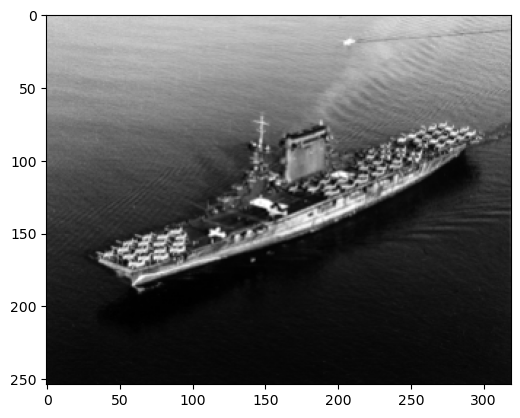

In [30]:
url = 'https://www.history.navy.mil/bin/imageDownload?image=/content/dam/nhhc/our-collections/photography/images/80-G-410000/80-G-416362&rendition=cq5dam.thumbnail.319.319.png'
img = io.imread(url, as_gray=True)

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')
ax.grid(False)

print(img.shape)
print(img.min(), img.max())
print(img[0, :10])
print(img[-1, -10:])


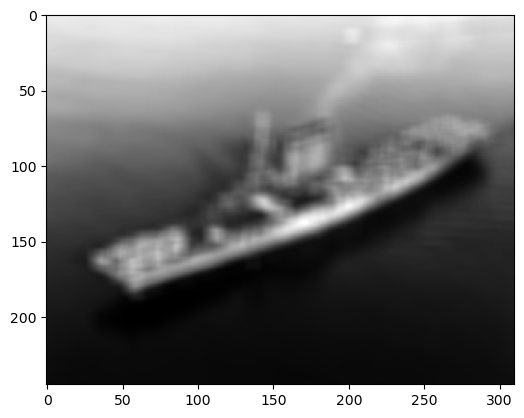

In [39]:
def py_convolution(img, size):
	m, n, *_ = img.shape
	mm = m - size + 1
	nn = n - size + 1

	patch_means = np.empty((mm, nn))
	for i in range(mm):
	    for j in range(nn):
	        patch_means[i, j] = img[i:i+size, j:j+size].mean()

	return patch_means

patch_means = py_convolution(img, size=10)
fig, ax = plt.subplots()
ax.imshow(patch_means, cmap='gray')
ax.grid(False)


True

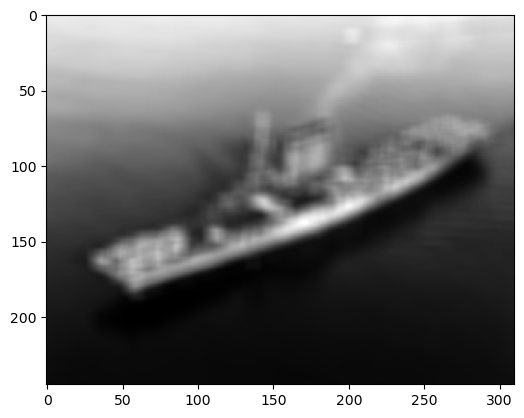

In [42]:
def numpy_convolution(img, size):
	shape = (img.shape[0] - size + 1, img.shape[1] - size + 1, size, size)
	strides = 2 * img.strides

	patches = stride_tricks.as_strided(img, shape=shape, strides=strides)
	return patches.mean(axis=(-1, -2))


strided_means = numpy_convolution(img, size=10)
fig, ax = plt.subplots()
ax.imshow(strided_means, cmap='gray')
ax.grid(False)

np.allclose(patch_means, strided_means)
